In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers

/Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework

Model: "mnist model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 784)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                330       
Total params: 26,506
Trainable params: 26,506
Non-trainable params: 0
_________________________________________________________________


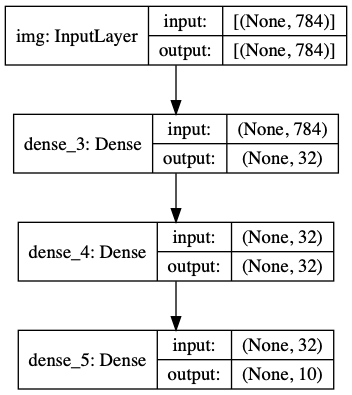

In [3]:
inputs = tf.keras.Input(shape=(784, ), name='img')
h1 = layers.Dense(32, activation='relu')(inputs)
h2 = layers.Dense(32, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h2)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist model')

model.summary()
tf.keras.utils.plot_model(model, 'mnist_model.png')
tf.keras.utils.plot_model(model, 'model_info.png', show_shapes=True)

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784) / 255.0
x_test = x_test.reshape(10000, 784) / 255.0

In [6]:
model.compile(optimizer=tf.optimizers.RMSprop(),
             loss=tf.losses.sparse_categorical_crossentropy,
             metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=5, batch_size=64)
test_scores = model.evaluate(x_test, y_test, verbose=0)
print('test loss:', test_scores[0])
print('test acc:', test_scores[1])

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 1s 23us/sample - loss: 0.1273 - accuracy: 0.9621
Epoch 2/5
60000/60000 [==============================] - 1s 19us/sample - loss: 0.1128 - accuracy: 0.9664
Epoch 3/5
60000/60000 [==============================] - 1s 19us/sample - loss: 0.1010 - accuracy: 0.9696
Epoch 4/5
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0924 - accuracy: 0.9724
Epoch 5/5
60000/60000 [==============================] - 1s 20us/sample - loss: 0.0849 - accuracy: 0.9752
test loss: 0.11969443798651919
test acc: 0.9662
